# Homework 3
## Mark Hendricks - Discussion

# Prepare the Data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../cmds')
from portfolio import *

In [2]:
facs = pd.read_excel('../data/factor_pricing_data.xlsx',sheet_name='factors (excess)').set_index('Date')
assets = pd.read_excel('../data/factor_pricing_data.xlsx',sheet_name='assets (excess)').set_index('Date')

FREQ = 12

In [3]:
display(assets.tail())
display(facs.tail())

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
2021-12-31,0.0804,-0.0445,0.0414,0.0308,0.0959,0.0177,0.0385,0.0856,0.0133,0.0673,0.0484,0.0529
2022-01-31,-0.0067,-0.1015,-0.0557,0.1735,-0.0625,-0.0827,-0.0199,-0.0210,-0.0895,-0.0860,-0.0062,-0.0621
2022-02-28,-0.0053,-0.0721,-0.0016,0.0808,-0.0347,-0.0514,0.0026,-0.0111,-0.0155,-0.0105,-0.0166,0.0022
2022-03-31,0.0041,0.1476,0.0128,0.0998,0.0002,0.0330,-0.0247,0.0968,0.0303,0.0515,-0.0096,0.0505
2022-04-30,0.0226,-0.1693,-0.0791,-0.0110,0.0052,-0.1266,-0.1071,-0.0371,-0.0990,-0.0674,-0.0795,-0.1025


,MKT,SMB,HML,UMD
Date,,,,
2021-12-31,0.0310,-0.0160,0.0322,-0.0260
2022-01-31,-0.0625,-0.0593,0.1274,-0.0250
2022-02-28,-0.0229,0.0218,0.0309,0.0175
2022-03-31,0.0306,-0.0161,-0.0182,0.0298
2022-04-30,-0.0944,-0.0140,0.0616,0.0482


# 2. Pricing Factor Stats

In [4]:
display(performanceMetrics(facs,annualization=12).style.format('{:.1%}'))

,Mean,Vol,Sharpe,Min,Max
MKT,8.4%,15.2%,55.5%,-17.2%,13.7%
SMB,1.2%,11.0%,11.1%,-17.3%,21.5%
HML,1.8%,11.1%,16.4%,-13.9%,12.7%
UMD,5.7%,16.3%,35.1%,-34.3%,18.2%


In [5]:
THRESH = .05
tailMetrics(facs,quantile=THRESH).style.format({
    'Skewness':'{:.2f}',
    'Kurtosis':'{:.2f}',
    'VaR (0.05)':'{:.1%}',
    'CVaR (0.05)':'{:.1%}',
    'Max Drawdown':'{:.1%}'
})

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
MKT,-0.60,1.25,-7.6%,-10.0%,-54.4%,2000-03-31 00:00:00,2009-02-28 00:00:00,2013-01-31 00:00:00,4689 days 00:00:00
SMB,0.63,7.31,-4.3%,-6.0%,-41.2%,1994-02-28 00:00:00,1999-03-31 00:00:00,2003-08-31 00:00:00,3471 days 00:00:00
HML,0.22,2.63,-4.2%,-6.7%,-58.5%,2006-12-31 00:00:00,2020-09-30 00:00:00,NaT,NaT
UMD,-1.44,10.39,-7.1%,-11.6%,-57.7%,2008-11-30 00:00:00,2009-09-30 00:00:00,NaT,NaT


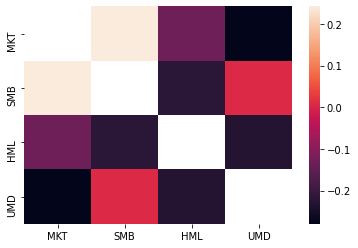

In [6]:
sns.heatmap(facs.corr().replace(1,np.nan));

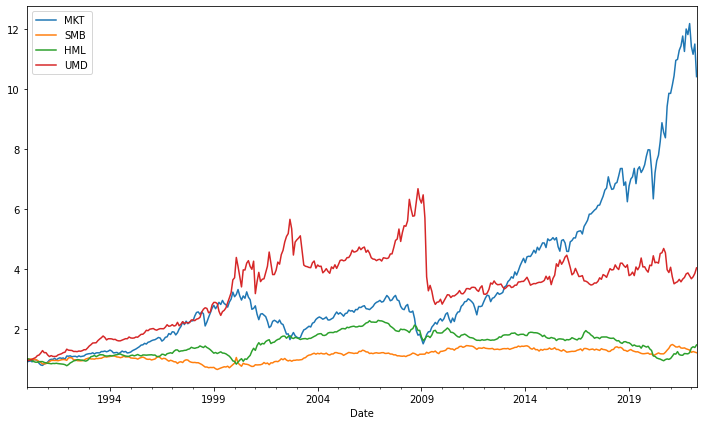

In [7]:
(facs+1).cumprod().plot(figsize=(12,7));

In [8]:
display(performanceMetrics(assets,annualization=12).style.format('{:.1%}'))

,Mean,Vol,Sharpe,Min,Max
NoDur,8.6%,13.2%,65.1%,-13.4%,14.2%
Durbl,10.6%,27.0%,39.4%,-33.0%,45.3%
Manuf,10.1%,18.5%,54.7%,-23.7%,20.8%
Enrgy,8.7%,22.0%,39.5%,-34.6%,32.4%
Chems,8.6%,14.8%,58.1%,-15.7%,12.6%
BusEq,12.5%,23.5%,53.1%,-26.4%,20.3%
Telcm,5.5%,17.5%,31.3%,-16.3%,21.2%
Utils,7.5%,13.8%,54.3%,-13.1%,11.2%
Shops,9.7%,16.1%,60.3%,-15.2%,18.0%
Hlth,9.7%,15.3%,63.3%,-12.7%,16.2%


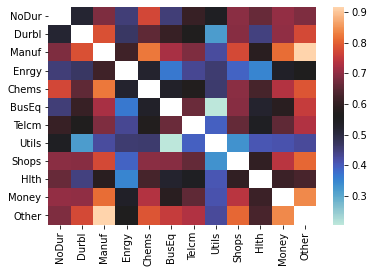

In [9]:
sns.heatmap((assets.corr()).replace(1,np.nan), cmap="icefire")
plt.show()

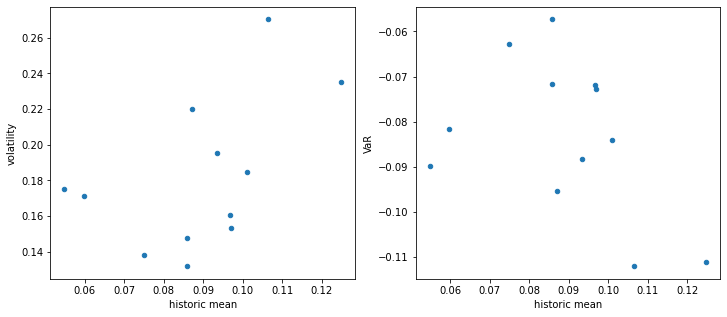

In [10]:
metrics = pd.DataFrame(assets.mean(),columns=['historic mean']) * FREQ
metrics['volatility'] = assets.std() * np.sqrt(FREQ)
metrics['VaR'] = assets.quantile(.05)

fig, ax = plt.subplots(1,2,figsize=(12,5))
metrics.plot.scatter(ax=ax[0], x='historic mean',y='volatility')
metrics.plot.scatter(ax=ax[1], x='historic mean',y='VaR')
plt.show()

# 2. CAPM

### Testing the model

In [11]:
regs_capm = get_ols_metrics(facs['MKT'],assets,annualization=FREQ)
display(regs_capm.style.format('{:.1%}'))

,alpha,MKT,r-squared,Treynor Ratio,Info Ratio
NoDur,3.3%,63.1%,52.9%,13.6%,36.0%
Durbl,-0.8%,136.1%,58.5%,7.8%,-4.8%
Manuf,0.8%,110.3%,82.3%,9.2%,10.3%
Enrgy,1.6%,84.4%,33.9%,10.3%,8.8%
Chems,2.1%,76.6%,61.9%,11.2%,23.3%
BusEq,1.2%,133.5%,74.3%,9.4%,10.3%
Telcm,-2.3%,92.4%,64.2%,5.9%,-22.1%
Utils,4.1%,40.9%,20.2%,18.3%,32.8%
Shops,2.1%,89.4%,71.6%,10.8%,24.9%
Hlth,3.6%,72.1%,51.0%,13.4%,33.7%


### Plot CAPM Fit

Plotting market beta against historic mean.

If CAPM fit, the scatter plot would (nearly) fit the line.

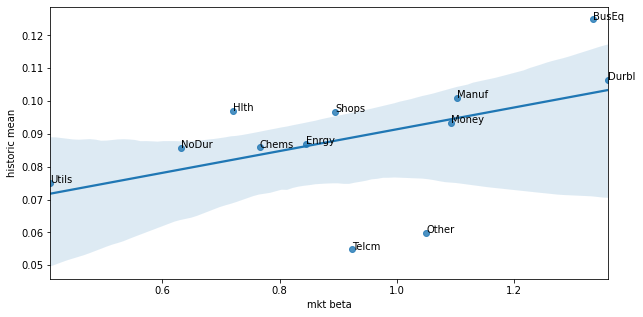

In [12]:
df = pd.DataFrame()
df['historic mean'] = assets.mean() * FREQ
df['mkt beta'] = regs_capm[['MKT']]
df.reset_index(inplace=True)

ax = sns.regplot(x='mkt beta',y='historic mean',data=df)
df[['mkt beta','historic mean','index']].apply(lambda x: ax.text(*x),axis=1);
plt.gcf().set_size_inches(10,5)
plt.show()

# 3. Multi-factor Models

### Testing the model

In [13]:
regs_facs = get_ols_metrics(facs,assets,annualization=FREQ)
display(regs_facs.style.format('{:.1%}'))

,alpha,MKT,SMB,HML,UMD,r-squared,Info Ratio
NoDur,2.6%,69.3%,-22.4%,18.1%,1.8%,59.3%,30.6%
Durbl,0.3%,128.3%,22.6%,39.0%,-25.3%,64.5%,1.8%
Manuf,0.7%,109.0%,9.9%,26.7%,-7.2%,85.7%,10.3%
Enrgy,-0.2%,89.5%,10.0%,66.4%,1.3%,44.4%,-1.5%
Chems,1.6%,81.3%,-17.0%,21.2%,-1.2%,66.8%,19.0%
BusEq,3.9%,120.7%,18.3%,-64.3%,-11.5%,84.2%,41.9%
Telcm,-1.8%,93.3%,-16.8%,-3.6%,-5.7%,65.4%,-17.4%
Utils,2.2%,51.3%,-21.9%,31.2%,11.9%,30.4%,19.0%
Shops,2.3%,89.5%,-3.2%,-0.6%,-1.5%,71.7%,26.5%
Hlth,3.4%,76.1%,-19.6%,-15.1%,6.6%,54.2%,32.9%


## Comparison

### Not using any pricing model

In [14]:
unconditional_mean_all = assets.mean().mean()
alphas_none = (assets.mean()-unconditional_mean_all)

In [15]:
MAE = pd.DataFrame(index=['none','CAPM','Multi'],dtype=float,columns=['MAE']) 
MAE.loc['CAPM'] = regs_capm['alpha'].abs().mean() 
MAE.loc['Multi'] = regs_facs['alpha'].abs().mean()
MAE.loc['none'] = alphas_none.abs().mean() * FREQ
MAE.style.format('{:.1%}')

,MAE
none,1.4%
CAPM,2.1%
Multi,1.9%


# 4. Extras

## Factor Models and MV Efficiency

In [16]:
wts_tan_all = tangency_weights(assets.join(facs))
display(wts_tan_all.T.style.format('{:.1%}'))

wts_tan_facs = tangency_weights(facs)
display(wts_tan_facs.T.style.format('{:.1%}'))

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,MKT,SMB,HML,UMD
tangency wts,14.8%,7.3%,29.7%,8.4%,18.0%,62.6%,11.2%,15.6%,28.2%,31.6%,22.9%,-47.4%,-170.9%,10.7%,31.3%,26.0%


,MKT,SMB,HML,UMD
tangency wts,39.6%,0.4%,28.9%,31.0%


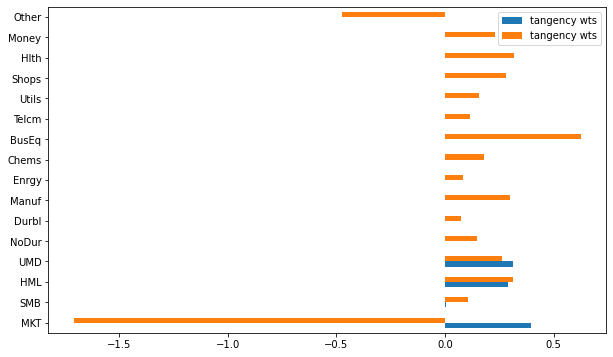

In [17]:
wts_tan = pd.concat([wts_tan_facs,wts_tan_all],axis=1)
wts_tan.plot.barh(figsize=(10,6));

## Testing Pricing Models with Cross-Sectional Regressions

Regress $\overline{r}^i$ on $\hat{\boldsymbol{\beta}^i}$ from the previous time-series regressions.

In [18]:
X = regs_facs[['MKT','SMB','HML','UMD']]
y = assets.mean()
reg_cs = sm.OLS(y,sm.add_constant(X)).fit()
print(reg_cs.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                 -0.101
Method:                 Least Squares   F-statistic:                    0.7481
Date:                Sun, 03 Jul 2022   Prob (F-statistic):              0.589
Time:                        22:25:47   Log-Likelihood:                 62.786
No. Observations:                  12   AIC:                            -115.6
Df Residuals:                       7   BIC:                            -113.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.005      1.066      0.3

/Users/markhendricks/Projects/FINM/finm-quant-2022/venv/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


We see that the R-squared is much less than 1, which means the betas do not fully explain expected returns.

The estimated intercept is near zero (and statistically insignficant,) so the issue is not that the expected returns are too high/low. Rather, it is that their variation does not correspond to variation in betas.

The estimated factor premium for HML is **negative**! And it is the most statistically significant factor. This throws doubt on the idea that the value factor is a source of premium--maybe we should be considering the growth factor!

### Plotting multifactor models

Given that there are multiple factors, we can't plot a single beta against the historic mean returns.

Rather, we can use the cross-sectional regression to fit the model-expected-return and plot that against the historic mean returns.

If the model fit, all the points would line up on the 45-degree line, (one-for-one.) 

In [ ]:
df = pd.DataFrame(columns=['mean return','predicted return'])
df['mean return'] = y 
df['predicted return'] = reg_cs.predict(sm.add_constant(X))
df *= FREQ

fig, ax = plt.subplots(figsize=(12,7)) 
df.plot(ax=ax, x='predicted return',y='mean return',kind='scatter',color='blue') 

y_line = np.arange(df.min().min(), df.max().max(), .005) 
x_line = y_line
ax.plot(y_line, x_line,color='k');

df.reset_index(inplace=True)
df[['predicted return','mean return','index']].apply(lambda x: ax.text(*x),axis=1);